In [1]:
!pip install pymc3 --upgrade  # This must be called every first run
!pip install PyAstronomy

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.10.0)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pymc3 as pm


from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##### OPTIONS #####

map = 1       # 1 - use find map, 0 - sample 
samples = 600  #if sampling, this is the number that decides the sampling and tuning
tune = 600

opt_params = 0   # if 1 use predetermined values

errorbars = 0   # plot error bars on surface plot 
smp_rt = 1     # every nth point of true data
num_gen =400 # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)
#!pip install pymc3 --upgrade  # This must be called every first run

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
Mass = data[:, 3][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()
BV =  b.bv2T(np.array(Teff))


# Age 

[10.92873499  0.53712399]


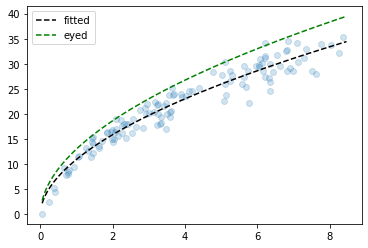

In [5]:


limit = (np.where(np.logical_and(Mass>0.9, Mass<=0.94)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]


plt.scatter(Age_short, Prot_short, alpha=0.2)



coefs = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Age_short,  Prot_short, p0=(10,0.5))
print(coefs[0])

x = np.linspace(np.amin(Age),np.amax(Age),1000)
y1 = coefs[0][0]* x **coefs[0][1]
y2 = 13*x**0.52
plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.plot(x,y2, color='g', linestyle='--', label='eyed')
plt.legend()



In [6]:
A = coefs[0][0]
c = coefs[0][1]
X = np.array([Age, Mass]).T 

with pm.Model() as model:

    A_ = pm.Normal('A_', A, A*0.5)
    c_ = pm.Normal('c_', c, c*0.3)
    mean = A_ * Age**c_

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.01)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.1), sigma=0.01)
    
    resid = Prot - mean

    sf2 = pm.Lognormal("sf2", mu=np.log(15), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=1)
    

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    K = K1 * K2

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=1.0)

    mp = pm.find_MAP()


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


{'A_': array(7.32095521), 'c_': array(0.77471615), 'l1_log__': array(2.63895506), 'l2_log__': array(-2.46994588), 'sf2_log__': array(1.15824468), 'sf1_log__': array(1.15824468), 'l1': array(13.9985683), 'l2': array(0.08458944), 'sf2': array(3.18433882), 'sf1': array(3.18433882)}


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


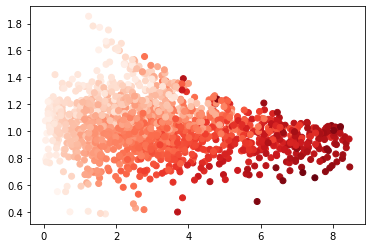

7.3209552149799375 0.7747161522908725


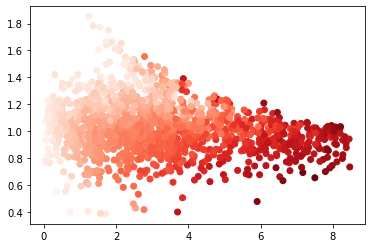

In [7]:
print(mp)
A = mp['A_']
c = mp['c_']

age_new = np.random.rand(400) * 8
mass_new = np.random.rand(400) * 1.0 + 0.4
Xnew = np.array([age_new, mass_new]).T
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=True)




plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.show()
plt.scatter(Age, Mass, c = mp['A_'] * Age**mp['c_'] + mu, cmap='Reds')

print(A, c)




[21.59579842 -0.97296007]


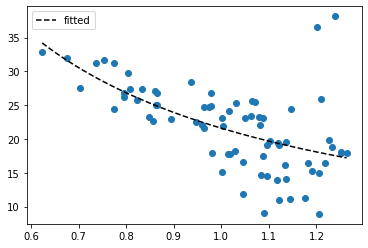

In [8]:
limit = (np.where(np.logical_and(Age>4.4, Age<=5)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]



plt.scatter(Mass_short, Prot_short)


coefs2 = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Mass_short,  Prot_short)
print(coefs2[0])

x = np.linspace(np.amin(Mass_short),np.amax(Mass_short),1000)
y1 = coefs2[0][0]* x **coefs2[0][1]

plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.legend()





-0.97296006677753


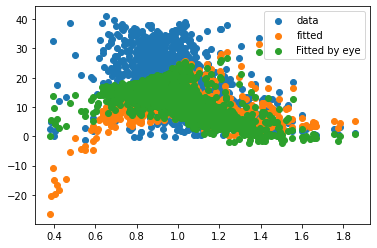

-0.009729600675217671


In [15]:
B = coefs2[0][0]
d = coefs2[0][1]
X = np.array([Age, Mass]).T 

print(d)

with pm.Model() as model:

    B_= pm.Normal('B_', B, B*0.5)
    d_ = pm.Uniform('d_', d, d*0.01)

    mean =  B_ *Mass**d_

    resid = Prot - mean


    l1 = pm.Lognormal('l1', mu=np.log(3.6), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.4), sigma=0.11)
  
    sf2 = pm.Lognormal("sf2", mu=np.log(160), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(160), sigma=1)

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    
    K = K1 * K2


    n = pm.HalfCauchy("n", beta=3)

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)
    
    mp = pm.find_MAP()

plt.scatter(Mass, Prot, label='data')
plt.scatter(Mass, A* Mass**mp['d_'] + mu, label='fitted')
plt.scatter(Mass, A* Mass**-1.6 + mu, label='Fitted by eye')
plt.legend()
plt.show()
print(mp['d_'])


The best fit value for d here does not fit the model very well. I do not like it. <br>The value determined through the linear regresssion fits far better, therefore I will be using that value going forward. 

https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [10]:
#### book ####
g = 0.77
h = 0.4 
f = 0.6 
c=0.52 

#determined 
d = d 
A = A 

X = np.array([Age, Mass, BV]).T 
K_b = b.bv2T(np.array(6200)) #  Kraft break

limit = (np.where(BV>K_b))

limit = (np.where(BV>0))

BV_short = BV[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]
X = np.array([Age_short, Mass_short, BV_short]).T 



with pm.Model() as model:

    f_ = pm.Normal('f_', f, f*0.5)
    A_ = pm.Normal('A_', A*g, A*0.3)
  
    mean = A_* Age_short**c   * Mass_short **d  * (BV_short - h)**f_
    resid = Prot_short - mean

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(3.6), sigma=0.11)
    l3 = pm.Lognormal('l3', mu=np.log(4), sigma=0.5)

    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)
    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)
    sf3 = pm.Lognormal('sf3', mu=np.log(45), sigma=10)

    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2

    K = K1 * K2 * K3

    n = 1 # noise = 1 as data generated with no noise
    
    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)

    mp = pm.find_MAP()

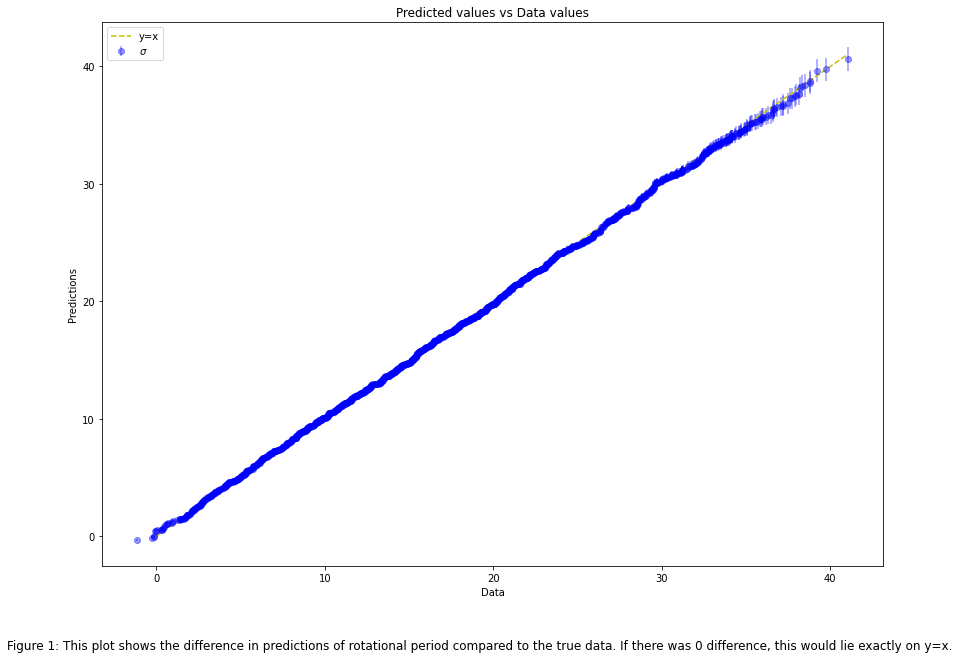

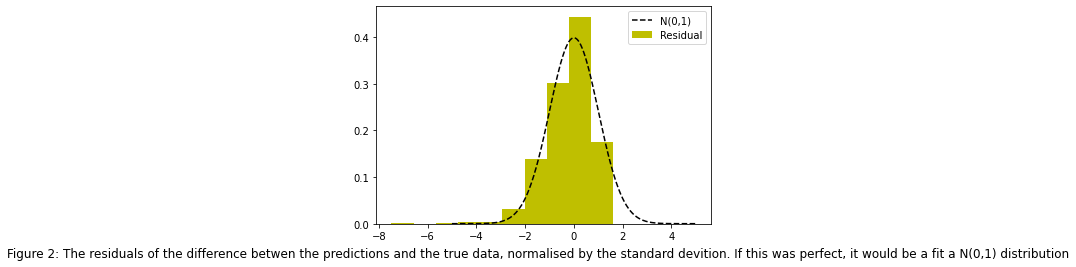

In [11]:
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=False)
sd = np.sqrt(var)

mean = mp['A_'] *Age**c   * Mass **d  * (BV - h)**mp['f_']

ydata = Prot
num_gen = len(Mass)
numElems = len(ydata)

idx = np.round(np.linspace(0, len(mu) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data


y_pred = mean + mu
mu_test = (mean + mu)
sd_test = sd


vals = np.sort([mu_test, sd_test], axis=1)

# sorts them together :) 

fig = plt.figure(figsize=(14, 10))

plt.plot([0, max(Prot)], [0, max(Prot)], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Prot_short), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")

txt="Figure 1: This plot shows the difference in predictions of rotational period compared to the true data. If there was 0 difference, this would lie exactly on y=x."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.show()

Z = (np.sort(Prot_short) - vals[0, :])/(vals[1, :])



x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Residual', color='y')
 
plt.plot(x,f, label='N(0,1)', color='k', linestyle='--')
txt="Figure 2: The residuals of the difference betwen the predictions and the true data, normalised by the standard devition. If this was perfect, it would be a fit a N(0,1) distribution"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.show()

These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

In [13]:
### TESTING latent variable 

# vars = A,c, d, f
g = 0.77
h = 0.4
f = 0.6
X = np.array([Age, Mass, BV]).T 
K_b = b.bv2T(np.array(6200)) #  Kraft break

limit = (np.where(BV>K_b))

limit = (np.where(BV>0))

BV_short = BV[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]
X = np.array([Age_short, Mass_short, BV_short]).T 

with pm.Model() as latent_gp_model:




    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(3.6), sigma=0.11)
    l3 = pm.Lognormal('l3', mu=np.log(4), sigma=0.5)

    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)
    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)
    sf3 = pm.Lognormal('sf3', mu=np.log(45), sigma=10)

    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2

    K = K1 * K2 * K3


        
    resid = Prot_short - mean
    n = 1

    gp = pm.gp.Latent(cov_func=K)




with latent_gp_model:
  ## for now just making predictions on f and A
    f = gp.prior("f", X=X)
    f_ = pm.Normal('f_', f, f*0.5)
    A_ = pm.Normal('A_', A*g, A*0.3)
  
    mean = A_* Age_short**c   * Mass_short **d  * (BV_short - h)**f_

-0.97296007


LinAlgError: ignored

Second fast component t the gp when we dont have B-V